In [1]:
# %config InlineBackend.figure_formats = ['svg']
import xyzpy as xyz
import combo_dynamics
from combo_dynamics import *
from math import pi
import quimb.tensor as qtn
import numpy as np
import os
from quimb.tensor.circuit import *
from quimb.tensor.circuit import Gate
import torch

# set single thread
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
# specify which gpu
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

/home/sijingdu/anaconda3/envs/BPSU/lib/python3.11/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


In [2]:
def coor2index(i, j, Lx, Ly):
    return i * Ly + j


def index2coor(index, Lx, Ly):
    return index // Ly, index % Ly


def bpsu_peps(
    peps,
    steps,
    chi=20,
    final_max_bond=20,
    max_iteration=1000,
    block=1,
    last_step=0,
    progbar=False,
    cutoff=5e-6,
    tol=5e-6,
    cutoff_mode="rsum2",
    optimize=None,
    compute_exact=True,
    rblock=0,
    plot=False,
    plot_final=False,
    lazy=False,
    damping=0.0,
):
    compressed_psi_list = []

    psi = peps.copy()

    for r in range(steps + last_step):
        # add another layer to the inner PEPO
        psi.retag_({
            f"ROUND_{r}": "OUTER"
        })  # rename the round r tag to OUTER to be compressed later
        if plot:
            psi.draw(color=['OUTER'], show_tags=False)
        rblock += 1
        if rblock < block:
            # keep accumulating into blocks
            continue
        else:
            # reset block counter
            rblock = 0

        if progbar:
            print(f"compressing layer {r}")

        psi, tn_outer = psi.partition(
            "OUTER", inplace=True
        )  # split the OUTER layer which consists of the PEPO-PEPS to be

        if r != steps + last_step - 1:
            # if not the last step, compress the OUTER layer to chi
            compress_l2bp(tn_outer,
                          max_bond=chi,
                          cutoff=cutoff,
                          max_iterations=max_iteration,
                          cutoff_mode=cutoff_mode,
                          tol=tol,
                          optimize=optimize,
                          progbar=progbar,
                          inplace=True,
                          lazy=lazy,
                          damping=damping,
                          update='sequential')
        else:
            # if the last step, compress the OUTER layer to final_max_bond
            compress_l2bp(tn_outer,
                          max_bond=final_max_bond,
                          cutoff=0.0,
                          max_iterations=max_iteration,
                          cutoff_mode=cutoff_mode,
                          tol=tol,
                          optimize=optimize,
                          progbar=progbar,
                          inplace=True,
                          lazy=lazy,
                          damping=damping,
                          update='sequential')

        if progbar:
            print("max_bond:", tn_outer.max_bond())
            # print(xyz.report_memory())
            # print(xyz.report_memory_gpu())

        tn_outer.equalize_norms_(value=1.0)

        current_psi = tn_outer.copy()

        compressed_psi_list.append(current_psi)

        psi.add_tensor_network(tn_outer, virtual=True)

        psi.check()

        if progbar:
            print("----------------------------------------------")

    if compute_exact:
        Nex = complex((psi.H & psi).contract(optimize=optimize))
        print(f"Exact norm = {Nex}")
    if plot_final:
        psi.draw(color=['PSI0'], show_tags=False)

    # compressed_psi_list.append(psi)

    return psi, compressed_psi_list


def tag_initial_state(psi, Lx, Ly):
    psi0 = psi.copy()
    for i in range(Lx * Ly):
        psi0.tensors[i].add_tag(['PSI0', 'ROUND_0'])
    return psi0


def peps2circpsi(peps, Lx, Ly):
    psi0 = peps.copy()
    for i in range(Lx * Ly):
        # psi0.tensors[i].add_tag(['PSI0','ROUND_0'])
        psi0.reindex_({"k{},{}".format(*index2coor(i, Lx, Ly)): f"k{i}"})
        psi0.retag_({'I{},{}'.format(*index2coor(i, Lx, Ly)): f"I{i}"})
    circ0 = Circuit(Lx * Ly, tags=['ROUND_0'])
    psi0.view_like_(circ0.psi)
    return psi0


def circpsi2peps(psi, Lx, Ly):
    peps0 = psi.copy()
    for i in range(Lx * Ly):
        peps0[f'I{i}'].add_tag([
            'X{}'.format(index2coor(i, Lx, Ly)[0]),
            'Y{}'.format(index2coor(i, Lx, Ly)[1])
        ])
        peps0.retag_({f"I{i}": "I{},{}".format(*index2coor(i, Lx, Ly))})
        peps0.reindex_({f"k{i}": "k{},{}".format(*index2coor(i, Lx, Ly))})

    peps = qtn.PEPS.from_TN(
        peps0,
        Lx=Lx,
        Ly=Ly,
        site_tag_id='I{},{}',
        site_ind_id='k{},{}',
        x_tag_id='X{}',
        y_tag_id='Y{}',
    )
    return peps


def generate_product_state(Lx, Ly, D):

    def fill_fn(shape):
        array = np.zeros(
            shape
        )  # except for the first element being 1, all other elements are 0
        # shape is a tuple of unknown length, so we use *shape to unpack it
        zeros = np.zeros(len(shape))
        array[tuple(zeros.astype(int))] = 1
        return array

    psi = qtn.PEPS.from_fill_fn(
        fill_fn,
        Lx,
        Ly,
        bond_dim=D,
    )
    return psi


def to_backend(x):
    # return torch.tensor on gpu
    return torch.tensor(x, dtype=torch.float64, device='cuda')

In [21]:
def run_BPSU(depth,
             Lx,
             Ly,
             j,
             g,
             tau_list,
             init_state=None,
             trotterization=False,
             second_order_reflect=False,
             factor=2.0,
             max_bond=32,
             final_max_bond=2,
             plot_circ=False,
             progbar=False,
             lazy=False,
             tol=5e-6,
             cutoff=5e-6,
             max_iteration=1000,
             damping=0.0,
             plot_intermediate=False,
             rand_init=False,
             gpu=False,
             compute_energy_every=10):
    H2 = qu.ham_heis(n=2, j=j)
    if g != 0:
        H1 = qu.ham_heis(n=1, b=(0, 0, g))
        ham = qtn.LocalHam2D(Lx, Ly, H2=H2, H1=H1)
    else:
        ham = qtn.LocalHam2D(Lx, Ly, H2=H2)

    psi_su = qtn.PEPS.rand(Lx, Ly, bond_dim=max_bond, seed=1)
    su = qtn.SimpleUpdate(
        psi_su,
        ham,
        chi=32,  # boundary contraction bond dim for computing energy
        compute_energy_every=10,
        compute_energy_per_site=True,
        keep_best=True,
    )
    # ordering = tuple(su.ordering()) + tuple(reversed(su.ordering())) # second_order_reflect ordering

    steps = depth * len(tau_list)

    #Manually construct the imaginary time evolution circuit, may contain bugs!!

    if init_state is None:
        if rand_init:
            psi0 = qtn.PEPS.rand(Lx, Ly, bond_dim=max_bond,
                                 seed=1)  # How to choose the seed?
            psi0 = peps2circpsi(psi0, Lx, Ly)
            circ = Circuit(Lx * Ly, psi0=psi0, tags=['ROUND_0'])
        else:
            circ = Circuit(Lx * Ly, tags=['ROUND_0'])
    else:
        psi0 = peps2circpsi(init_state, Lx, Ly)
        circ = Circuit(Lx * Ly, psi0=psi0, tags=['ROUND_0'])
    # print(circ.psi)

    for tau in tau_list:
        for r in range(depth):
            if not trotterization:
                if second_order_reflect:
                    for where in tuple(su.ordering()) + tuple(
                            reversed(su.ordering())):
                        qubits = (coor2index(*where[0], Lx, Ly),
                                  coor2index(*where[1], Lx, Ly))
                        U = ham.get_gate_expm(where, -tau / factor)
                        # print(np.linalg.eig(U))
                        # mygate = parse_to_gate(U,*qubits,gate_round=1)
                        # print(mygate)
                        circ.apply_gate(U,
                                        *qubits,
                                        gate_round=r +
                                        depth * tau_list.index(tau),
                                        parametrize=None,
                                        params=tau,
                                        contract='split-gate')
                else:
                    for where in tuple(su.ordering()):
                        qubits = (coor2index(*where[0], Lx, Ly),
                                  coor2index(*where[1], Lx, Ly))
                        U = ham.get_gate_expm(where, -tau)
                        # print(np.linalg.eig(U))
                        # mygate = parse_to_gate(U,*qubits,gate_round=1)
                        # print(mygate)
                        circ.apply_gate(U,
                                        *qubits,
                                        gate_round=r +
                                        depth * tau_list.index(tau),
                                        parametrize=None,
                                        params=tau,
                                        contract='split-gate')
            else:
                XX = np.kron(qu.pauli('X'), qu.pauli('X'))
                YY = np.kron(qu.pauli('Y'), qu.pauli('Y'))
                ZZ = np.kron(qu.pauli('Z'), qu.pauli('Z'))
                import scipy.linalg as la
                for gate_matrix in [XX, YY, ZZ]:
                    for where in tuple(su.ordering()):
                        qubits = (coor2index(*where[0], Lx, Ly),
                                  coor2index(*where[1], Lx, Ly))
                        U = la.expm(-1 * gate_matrix * tau)
                        circ.apply_gate(U,
                                        *qubits,
                                        gate_round=r +
                                        depth * tau_list.index(tau),
                                        parametrize=None,
                                        params=tau,
                                        contract='split-gate')

                    # print(np.linalg.eig(U))
                    # mygate = parse_to_gate(U,*qubits,gate_round=1)
                    # print(mygate)
                    # circ.apply_gate(U, *qubits, gate_round=r+depth*tau_list.index(tau),
                    #                 parametrize=None,params=tau,contract='split-gate')

    psi_circ = circ.psi
    if plot_circ:
        psi_circ.draw(show_tags=False,
                      color=['PSI0', 'ROUND_0', f'ROUND_{steps-1}'])
    if gpu:
        print('Using GPU')
        psi_circ.apply_to_arrays(to_backend)
        print('Done')

    final_bp_peps, peps_list = bpsu_peps(
        psi_circ,
        steps=steps,
        chi=max_bond,
        final_max_bond=final_max_bond,
        plot=plot_intermediate,
        compute_exact=False,
        progbar=progbar,
        lazy=lazy,
        tol=tol,
        cutoff=cutoff,
        max_iteration=max_iteration,
        damping=damping,
    )

    def compute_energy(circpsi):
        circ_peps = circpsi2peps(circpsi, Lx, Ly)
        if gpu:
            ham.apply_to_arrays(to_backend)
        energy = circ_peps.compute_local_expectation(
            ham.terms,
            max_bond=32,
            normalized=True,
        )
        return energy / (Lx * Ly)

    def reindex_circpsi_(psi):
        outer_inds = psi.outer_inds()
        site_inds = psi.site_inds
        # combine outer_inds and site_inds into a dictionary
        inds_dict = dict(zip(outer_inds, site_inds))
        # reindex the psi into PEPS outer indices
        psi.reindex_(inds_dict)

    Final_energy = compute_energy(final_bp_peps)
    print(f'Final energy = {Final_energy}')

    energy_list = []
    step_list = []

    for i in range(len(peps_list)):
        # compute energy every "compute_energy_every" steps
        if (i + 1) % compute_energy_every == 0:
            reindex_circpsi_(peps_list[i])
            energy_list.append(compute_energy(peps_list[i]))
            step_list.append(i + 1)

    return Final_energy, final_bp_peps, energy_list, step_list, peps_list


def get_gate_su(j):
    """
        Here all the Hamiltonian terms in Heisenberg model are real operators. (Sy*Sy->real matrix)
        The final matrix has shape (4,4) and is not in tensor product form.
    """
    sx = np.array([[0, 1], [1, 0]]) * .5
    sy = np.array([[0, -1], [1, 0]]) * 1j * .5
    sz = np.array([[1, 0], [0, -1]]) * .5
    try:
        jx, jy, jz = j
    except TypeError:
        j = j, j, j
    data = np.zeros((4, 4))
    for coeff, op in zip(j, [sx, sy, sz]):
        data += coeff * np.kron(op, op).real
    return data


def run_BPSU_ham(depth,
                 Lx,
                 Ly,
                 ham,
                 tau_list,
                 init_state=None,
                 trotterization=False,
                 second_order_reflect=False,
                 factor=2.0,
                 max_bond=32,
                 final_max_bond=2,
                 plot_circ=False,
                 progbar=False,
                 lazy=False,
                 tol=5e-6,
                 cutoff=5e-6,
                 max_iteration=1000,
                 damping=0.0,
                 plot_intermediate=False,
                 rand_init=False,
                 gpu=False,
                 compute_energy_every=10):

    psi_su = qtn.PEPS.rand(Lx, Ly, bond_dim=max_bond, seed=1)
    su = qtn.SimpleUpdate(
        psi_su,
        ham,
        chi=32,  # boundary contraction bond dim for computing energy
        compute_energy_every=10,
        compute_energy_per_site=True,
        keep_best=True,
    )

    steps = depth * len(tau_list)

    # Manually construct the imaginary time evolution circuit, may contain bugs!!

    if init_state is None:
        if rand_init:
            psi0 = qtn.PEPS.rand(Lx, Ly, bond_dim=max_bond,
                                 seed=1)  # How to choose the seed?
            psi0 = peps2circpsi(psi0, Lx, Ly)
            circ = Circuit(Lx * Ly, psi0=psi0, tags=['ROUND_0'])
        else:
            circ = Circuit(Lx * Ly, tags=['ROUND_0'])
    else:
        psi0 = peps2circpsi(init_state, Lx, Ly)
        circ = Circuit(Lx * Ly, psi0=psi0, tags=['ROUND_0'])
    # print(circ.psi)

    for tau in tau_list:
        for r in range(depth):
            if not trotterization:
                if second_order_reflect:
                    for where in tuple(su.ordering()) + tuple(
                            reversed(su.ordering())):
                        qubits = (coor2index(*where[0], Lx, Ly),
                                  coor2index(*where[1], Lx, Ly))
                        U = ham.get_gate_expm(where, -tau / factor)
                        # print(np.linalg.eig(U))
                        # mygate = parse_to_gate(U,*qubits,gate_round=1)
                        # print(mygate)
                        circ.apply_gate(
                            U,
                            *qubits,
                            gate_round=r + depth * tau_list.index(tau),
                            parametrize=None,
                            params=tau,
                            contract='split-gate',
                        )
                else:
                    for where in tuple(su.ordering()):
                        qubits = (coor2index(*where[0], Lx, Ly),
                                  coor2index(*where[1], Lx, Ly))
                        U = ham.get_gate_expm(where, -tau)
                        # print(np.linalg.eig(U))
                        # mygate = parse_to_gate(U,*qubits,gate_round=1)
                        # print(mygate)
                        circ.apply_gate(U,
                                        *qubits,
                                        gate_round=r +
                                        depth * tau_list.index(tau),
                                        parametrize=None,
                                        params=tau,
                                        contract='split-gate')
            else:
                return NotImplementedError(
                    'Trotterization not implemented for custom Hamiltonian')

    psi_circ = circ.psi
    if plot_circ:
        psi_circ.draw(show_tags=False,
                      color=['PSI0', 'ROUND_0', f'ROUND_{steps-1}'])
    if gpu:
        print('Using GPU')
        psi_circ.apply_to_arrays(to_backend)
        print('Done')

    final_bp_psi, psi_list = bpsu_peps(
        psi_circ,
        steps=steps,
        chi=max_bond,
        final_max_bond=final_max_bond,
        plot=plot_intermediate,
        compute_exact=False,
        progbar=progbar,
        lazy=lazy,
        tol=tol,
        cutoff=cutoff,
        max_iteration=max_iteration,
        damping=damping,
    )
    final_bp_peps = circpsi2peps(final_bp_psi, Lx, Ly)
    peps_list = [circpsi2peps(psi, Lx, Ly) for psi in psi_list]
    return final_bp_peps, peps_list
    # return final_bp_psi, circpsi2peps(final_bp_psi,Lx,Ly)

    # def compute_energy(circpsi):
    #     circ_peps = circpsi2peps(circpsi,Lx,Ly)
    #     if gpu:
    #         ham.apply_to_arrays(to_backend)
    #     energy = circ_peps.compute_local_expectation(
    #         ham.terms,
    #         max_bond=32,
    #         normalized=True,
    #     )
    #     return energy/(Lx*Ly)

    # def reindex_circpsi_(psi):
    #     outer_inds = psi.outer_inds()
    #     site_inds = psi.site_inds
    #     # combine outer_inds and site_inds into a dictionary
    #     inds_dict = dict(zip(outer_inds, site_inds))
    #     # reindex the psi into PEPS outer indices
    #     psi.reindex_(inds_dict)

    # Final_energy = compute_energy(final_bp_peps)
    # print(f'Final energy = {Final_energy}')

    # energy_list = []
    # step_list = []

    # for i in range(len(peps_list)):
    #     # compute energy every "compute_energy_every" steps
    #     if (i+1)%compute_energy_every == 0:
    #         reindex_circpsi_(peps_list[i])
    #         energy_list.append(compute_energy(peps_list[i]))
    #         step_list.append(i+1)

    # return Final_energy, final_bp_peps, energy_list, step_list, peps_list

In [4]:
# # SimpleUpdate Heisenberg model
# D=2 # Simple update initial PEPS bond dimension
# j=(1,1,1)
# g=0
# Lx=Ly=4
# tau_list=[0.5,0.1]
# n_steps=50
# # import torch

# # if torch.cuda.is_available():
# #     device = 'cuda'
# # else:
# #     device = 'cpu'

# H2 = qu.ham_heis(n=2, j=j)
# if g != 0:
#     H1 = qu.ham_heis(n=1, b=(0,0,g))
#     ham = qtn.LocalHam2D(Lx, Ly, H2=H2, H1=H1)
# else:
#     ham = qtn.LocalHam2D(Lx, Ly, H2=H2)
# ham.apply_to_arrays(to_backend)
# def fill_fn(shape):
#     array = np.zeros(shape) # except for the first element being 1, all other elements are 0
#     # shape is a tuple of unknown length, so we use *shape to unpack it
#     zeros = np.zeros(len(shape))
#     array[tuple(zeros.astype(int))] = 1
#     return array

In [5]:
# # D=2 -> D=2
# init_peps = qtn.PEPS.rand(Lx, Ly, bond_dim=D,seed=1)
# init_peps.apply_to_arrays(to_backend)
# su_test = qtn.SimpleUpdate(
#     init_peps,
#     ham,
#     D=2,
#     chi=32,  # boundary contraction bond dim for computing energy
#     compute_energy_every=5,
#     compute_energy_per_site=True,
#     keep_best=True,
#     second_order_reflect=True,
#     ordering=None,
# )
# for (ija, ijb), Tsval in su_test.gauges.items():
#     Tsval.apply_to_arrays(to_backend)
# tau_list_test = [1,0.5,0.1]
# n_list = [50,50,50]
# for i in range(len(tau_list_test)):
#     su_test.evolve(n_list[i], tau=tau_list_test[i])

In [4]:
# SimpleUpdate J1J2 model
D = 2
Lx, Ly = 4, 4

J1 = 1.
J2 = 0.5

h2 = get_gate_su(1.)
terms = dict()
for i in range(Lx):
    for j in range(Ly):
        if j < Ly - 1:
            where = (i, j), (i, j + 1)
        terms[where] = h2
        if i < Lx - 1:
            where = (i, j), (i + 1, j)
        terms[where] = h2

terms_ = dict()
for i in range(Lx):
    for j in range(Ly):
        if i + 1 < Lx and j + 1 < Ly:
            where = (i, j), (i + 1, j + 1)
            terms_[where] = h2 * J2
            where = (i, j + 1), (i + 1, j)
            terms_[where] = h2 * J2
        # else:
        #     ix1,ix2 = flatten(i,j,Ly),flatten((i+1)%Lx,(j+1)%Ly,Ly)
        #     where = flat2site(min(ix1,ix2),Lx,Ly),flat2site(max(ix1,ix2),Lx,Ly)
        #     terms_[where] = h2 * J2

        #     ix1,ix2 = flatten(i,(j+1)%Ly,Ly),flatten((i+1)%Lx,j,Ly)
        #     where = flat2site(min(ix1,ix2),Lx,Ly),flat2site(max(ix1,ix2),Lx,Ly)
        #     terms_[where] = h2 * J2
terms.update(terms_)
ham = qtn.LocalHam2D(Lx, Ly, terms)
# ham.apply_to_arrays(to_backend)
# D=2 -> D=2
init_peps = qtn.PEPS.rand(Lx, Ly, bond_dim=D, seed=1)
# init_peps.apply_to_arrays(to_backend)

su = qtn.SimpleUpdate(
    init_peps,
    ham,
    D=2,
    chi=32,  # boundary contraction bond dim for computing energy
    compute_energy_every=5,
    compute_energy_per_site=True,
    keep_best=True,
    second_order_reflect=True,
    ordering=None,
)
# for (ija, ijb), Tsval in su.gauges.items():
#     Tsval.apply_to_arrays(to_backend)

tau_list = [0.5, 0.2, 0.05]
n_list = [10, 10, 10]
for i in range(len(tau_list)):
    su.evolve(n_list[i], tau=tau_list[i])

  0%|          | 0/10 [00:00<?, ?it/s]/home/sijingdu/anaconda3/envs/BPSU/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:55: UserWarning: Couldn't find `optuna`, `baytune (btb)`, `chocolate`, `nevergrad` or `skopt` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(
n=30, tau=0.0500, energy~-0.435801: 100%|##########| 10/10 [00:00<00:00, 16.68it/s]


In [113]:
su.long_range_path_sequence

'random'

In [5]:
psi_su = su.state
# psi.compute_local_expectation(ham.terms, max_bond=32, normalized=True)/(Lx*Ly)
psi_su

PEPS(tensors=16, indices=40, Lx=4, Ly=4, max_bond=2)

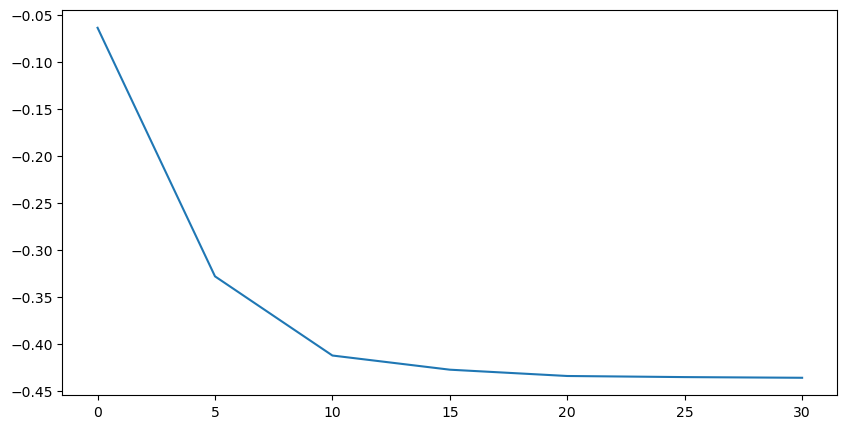

In [7]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(su.its[:], su.energies[:], label='Heisenberg')


In [25]:
final_peps, peps_list = run_BPSU_ham(depth=10,
                                     Lx=4,
                                     Ly=4,
                                     ham=ham,
                                     tau_list=tau_list,
                                     init_state=init_peps,
                                     progbar=True,
                                     max_bond=2,
                                     final_max_bond=2,
                                     tol=5e-6,
                                     cutoff=0.0,
                                     damping=0.25,
                                     compute_energy_every=10)


compressing layer 0


nconv: 8/8 max|dM|=1.81e-06: : 30it [00:00, 41.68it/s]  


max_bond: 2
----------------------------------------------
compressing layer 1


nconv: 8/8 max|dM|=4.27e-06: : 31it [00:00, 38.55it/s]  


max_bond: 2
----------------------------------------------
compressing layer 2


nconv: 18/18 max|dM|=4.65e-06: : 35it [00:00, 38.88it/s]


max_bond: 2
----------------------------------------------
compressing layer 3


nconv: 22/22 max|dM|=4.93e-06: : 43it [00:01, 38.78it/s]


max_bond: 2
----------------------------------------------
compressing layer 4


nconv: 14/14 max|dM|=4.81e-06: : 51it [00:01, 42.27it/s]


max_bond: 2
----------------------------------------------
compressing layer 5


nconv: 12/14 max|dM|=8.34e-06: : 51it [00:01, 41.19it/s]


max_bond: 2
----------------------------------------------
compressing layer 6


nconv: 23/23 max|dM|=4.92e-06: : 42it [00:00, 43.22it/s]


max_bond: 2
----------------------------------------------
compressing layer 7


nconv: 11/11 max|dM|=2.95e-06: : 53it [00:01, 43.09it/s]


max_bond: 2
----------------------------------------------
compressing layer 8


nconv: 22/22 max|dM|=3.36e-06: : 54it [00:01, 43.70it/s]


max_bond: 2
----------------------------------------------
compressing layer 9


nconv: 4/4 max|dM|=2.14e-06: : 53it [00:01, 43.11it/s]  


max_bond: 2
----------------------------------------------
compressing layer 10


nconv: 7/7 max|dM|=2.16e-06: : 41it [00:00, 43.40it/s]  


max_bond: 2
----------------------------------------------
compressing layer 11


nconv: 11/11 max|dM|=3.40e-06: : 39it [00:00, 42.82it/s]


max_bond: 2
----------------------------------------------
compressing layer 12


nconv: 18/18 max|dM|=3.01e-06: : 38it [00:00, 42.53it/s]


max_bond: 2
----------------------------------------------
compressing layer 13


nconv: 11/11 max|dM|=3.18e-06: : 36it [00:00, 42.39it/s]


max_bond: 2
----------------------------------------------
compressing layer 14


nconv: 7/7 max|dM|=2.51e-06: : 35it [00:00, 41.71it/s]  


max_bond: 2
----------------------------------------------
compressing layer 15


nconv: 11/11 max|dM|=4.91e-06: : 32it [00:00, 42.14it/s]


max_bond: 2
----------------------------------------------
compressing layer 16


nconv: 23/23 max|dM|=4.28e-06: : 31it [00:00, 40.18it/s]


max_bond: 2
----------------------------------------------
compressing layer 17


nconv: 11/11 max|dM|=2.39e-06: : 30it [00:00, 40.14it/s]


max_bond: 2
----------------------------------------------
compressing layer 18


nconv: 24/24 max|dM|=4.05e-06: : 26it [00:00, 40.22it/s]


max_bond: 2
----------------------------------------------
compressing layer 19


nconv: 14/14 max|dM|=2.68e-06: : 25it [00:00, 39.79it/s]


max_bond: 2
----------------------------------------------
compressing layer 20


nconv: 12/12 max|dM|=3.69e-06: : 20it [00:00, 39.43it/s]


max_bond: 2
----------------------------------------------
compressing layer 21


nconv: 18/18 max|dM|=3.77e-06: : 20it [00:00, 39.31it/s]


max_bond: 2
----------------------------------------------
compressing layer 22


nconv: 11/11 max|dM|=2.50e-06: : 19it [00:00, 38.81it/s]


max_bond: 2
----------------------------------------------
compressing layer 23


nconv: 33/33 max|dM|=4.83e-06: : 18it [00:00, 37.27it/s]


max_bond: 2
----------------------------------------------
compressing layer 24


nconv: 13/13 max|dM|=1.96e-06: : 19it [00:00, 38.79it/s]


max_bond: 2
----------------------------------------------
compressing layer 25


nconv: 24/24 max|dM|=2.52e-06: : 19it [00:00, 38.81it/s]


max_bond: 2
----------------------------------------------
compressing layer 26


nconv: 7/7 max|dM|=1.41e-06: : 19it [00:00, 38.83it/s]  


max_bond: 2
----------------------------------------------
compressing layer 27


nconv: 7/7 max|dM|=1.20e-06: : 19it [00:00, 41.20it/s]  


max_bond: 2
----------------------------------------------
compressing layer 28


nconv: 18/18 max|dM|=4.75e-06: : 18it [00:00, 36.90it/s]


max_bond: 2
----------------------------------------------
compressing layer 29


nconv: 11/11 max|dM|=2.86e-06: : 18it [00:00, 39.09it/s]


max_bond: 2
----------------------------------------------


In [26]:
final_peps.compute_local_expectation(ham.terms, max_bond=10,
                                     normalized=True) / (Lx * Ly)

-0.42285827462943226

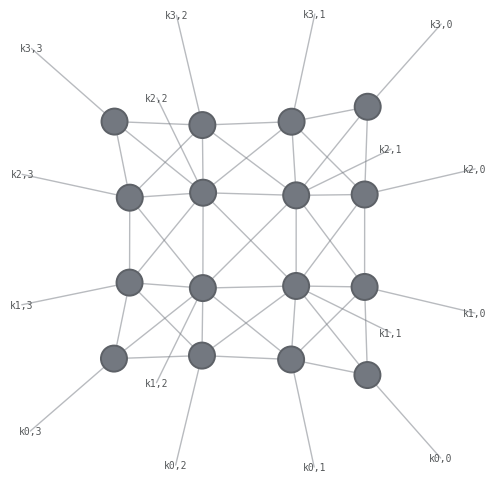

In [24]:
final_peps.draw()

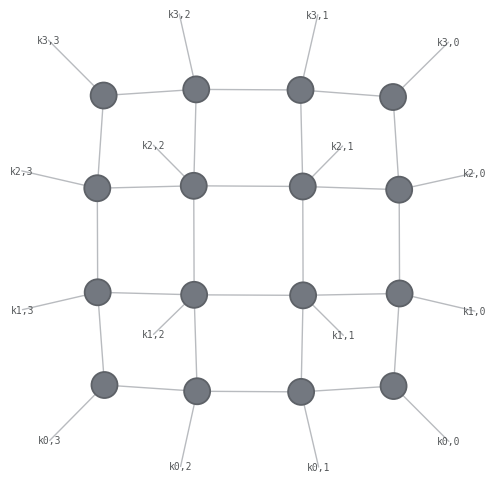

In [121]:
psi_su.draw()